In [1]:
import time
import datetime
import json
import os
import pandas as pd
import sys
import pysam
from scipy.special import logsumexp

stderr = sys.stderr
sys.stderr = open('keras.stderr', 'w')

from basepairmodels.cli import argparsers
from basepairmodels.cli import bigwigutils
from basepairmodels.cli import logger
from basepairmodels.cli import MTBatchGenerator

from basepairmodels.cli.batchgenutils import *
from basepairmodels.cli.bpnetutils import *
from basepairmodels.cli.losses import MultichannelMultinomialNLL, multinomial_nll

sys.stderr = stderr

from keras.models import load_model
from keras.utils import CustomObjectScope
from mseqgen import quietexception
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
from plotnine import *

import keras.backend as kb

import imageio

Using TensorFlow backend.


In [2]:
def get_model(model_path):
    with CustomObjectScope({'MultichannelMultinomialNLL': 
                                MultichannelMultinomialNLL,"kb": kb,
                           "profile_loss": lambda true_vals, pred_vals: pred_vals,
                            "count_loss": lambda true_vals, pred_vals: pred_vals}):
        model = load_model(model_path)
    return model
    
def random_seq(seqlen):
    return ''.join(random.choices("ACGT", k=seqlen))



In [4]:
model_path = '/oak/stanford/groups/akundaje/amtseng/tfmodisco/results/best_models_bigwigs/models/JUND_task4_model.h5'
reference_genome = '/users/zahoor/reference/hg38.genome.fa'
peak_path  = '/oak/stanford/groups/akundaje/amtseng/tfmodisco/results/best_models_bigwigs/peaks/JUND_task11_peaks.bed.gz'



In [5]:
model = get_model(model_path=model_path)

In [6]:
def dinuc_shuffle(seq, num_shufs=None, rng=None):
    """
    Creates shuffles of the given sequence, in which dinucleotide frequencies
    are preserved.
    Arguments:
        `seq`: either a string of length L, or an L x D NumPy array of one-hot
            encodings
        `num_shufs`: the number of shuffles to create, N; if unspecified, only
            one shuffle will be created
        `rng`: a NumPy RandomState object, to use for performing shuffles
    If `seq` is a string, returns a list of N strings of length L, each one
    being a shuffled version of `seq`. If `seq` is a 2D NumPy array, then the
    result is an N x L x D NumPy array of shuffled versions of `seq`, also
    one-hot encoded. If `num_shufs` is not specified, then the first dimension
    of N will not be present (i.e. a single string will be returned, or an L x D
    array).
    """
    if type(seq) is str:
        arr = string_to_char_array(seq)
    elif type(seq) is np.ndarray and len(seq.shape) == 2:
        seq_len, one_hot_dim = seq.shape
        arr = one_hot_to_tokens(seq)
    else:
        raise ValueError("Expected string or one-hot encoded array")

    if not rng:
        rng = np.random.RandomState()
   
    # Get the set of all characters, and a mapping of which positions have which
    # characters; use `tokens`, which are integer representations of the
    # original characters
    chars, tokens = np.unique(arr, return_inverse=True)

    # For each token, get a list of indices of all the tokens that come after it
    shuf_next_inds = []
    for t in range(len(chars)):
        mask = tokens[:-1] == t  # Excluding last char
        inds = np.where(mask)[0]
        shuf_next_inds.append(inds + 1)  # Add 1 for next token
 
    if type(seq) is str:
        all_results = []
    else:
        all_results = np.empty(
            (num_shufs if num_shufs else 1, seq_len, one_hot_dim),
            dtype=seq.dtype
        )

    for i in range(num_shufs if num_shufs else 1):
        # Shuffle the next indices
        for t in range(len(chars)):
            inds = np.arange(len(shuf_next_inds[t]))
            inds[:-1] = rng.permutation(len(inds) - 1)  # Keep last index same
            shuf_next_inds[t] = shuf_next_inds[t][inds]

        counters = [0] * len(chars)
       
        # Build the resulting array
        ind = 0
        result = np.empty_like(tokens)
        result[0] = tokens[ind]
        for j in range(1, len(tokens)):
            t = tokens[ind]
            ind = shuf_next_inds[t][counters[t]]
            counters[t] += 1
            result[j] = tokens[ind]

        if type(seq) is str:
            all_results.append(char_array_to_string(chars[result]))
        else:
            all_results[i] = tokens_to_one_hot(chars[result], one_hot_dim)
    return all_results if num_shufs else all_results[0]
def string_to_char_array(seq):
    """
    Converts an ASCII string to a NumPy array of byte-long ASCII codes.
    e.g. "ACGT" becomes [65, 67, 71, 84].
    """
    return np.frombuffer(bytearray(seq, "utf8"), dtype=np.int8)


def char_array_to_string(arr):
    """
    Converts a NumPy array of byte-long ASCII codes into an ASCII string.
    e.g. [65, 67, 71, 84] becomes "ACGT".
    """
    return arr.tostring().decode("ascii")


def one_hot_to_tokens(one_hot):
    """
    Converts an L x D one-hot encoding into an L-vector of integers in the range
    [0, D], where the token D is used when the one-hot encoding is all 0. This
    assumes that the one-hot encoding is well-formed, with at most one 1 in each
    column (and 0s elsewhere).
    """
    tokens = np.tile(one_hot.shape[1], one_hot.shape[0])  # Vector of all D
    seq_inds, dim_inds = np.where(one_hot)
    tokens[seq_inds] = dim_inds
    return tokens


def tokens_to_one_hot(tokens, one_hot_dim):
    """
    Converts an L-vector of integers in the range [0, D] to an L x D one-hot
    encoding. The value `D` must be provided as `one_hot_dim`. A token of D
    means the one-hot encoding is all 0s.
    """
    identity = np.identity(one_hot_dim + 1)[:, :-1]  # Last row is all 0s
    return identity[tokens]

In [7]:

def get_suffled_peak_sequences(peak_path,fasta_path = '/users/zahoor/reference/hg38.genome.fa', input_seq_len = 2114,
                               num_of_simulated_sequences=1000):
    peaks_df = pd.read_csv(peak_path,
                           sep='\t',header=None,
                           names=['chrom', 'start', 'end', 'name', 'score',
                                      'strand', 'signalValue', 'p', 'q', 'summit'])

    peaks_df = peaks_df.sample(frac=1).reset_index(drop=True)

    fasta_ref = pysam.FastaFile(fasta_path)

    sequences = []

    Input_start = peaks_df['start'] + peaks_df['summit'] - (input_seq_len//2)
    Input_start = Input_start.mask(Input_start < 0,0)
    Input_end = peaks_df['start'] + peaks_df['summit'] + (input_seq_len//2)


    for i in range(num_of_simulated_sequences):
        actual_sequence = fasta_ref.fetch(peaks_df['chrom'][i], Input_start[i] , Input_end[i]).upper()
        padded_sequence = actual_sequence+(random_seq(input_seq_len-len(actual_sequence)))
        shuffled_seq = dinuc_shuffle(padded_sequence)
        sequences.append(shuffled_seq)
    
    return sequences

In [8]:
sequences = get_suffled_peak_sequences(peak_path)

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


In [9]:
def logits_to_profile(logits_vals,counts_vals):
    probVals = logits_vals - logsumexp(logits_vals)
    probVals = np.exp(probVals)
    profile = np.multiply(np.exp(counts_vals)-1, probVals)
    return profile



In [10]:
def calculate_average_profile(prediction,task=0):
    plus = []
    minus = []

    for i in range(len(prediction[1])):
        minus.append(logits_to_profile(logits_vals = prediction[0][i][task,:,0],counts_vals = prediction[1][i][task,0]))
        plus.append(logits_to_profile(logits_vals = prediction[0][i][task,:,1],counts_vals = prediction[1][i][task,1]))
        plus_avg = np.vstack(plus).mean(axis=0)
        minus_avg = np.vstack(minus).mean(axis=0)
    return(plus_avg,minus_avg)

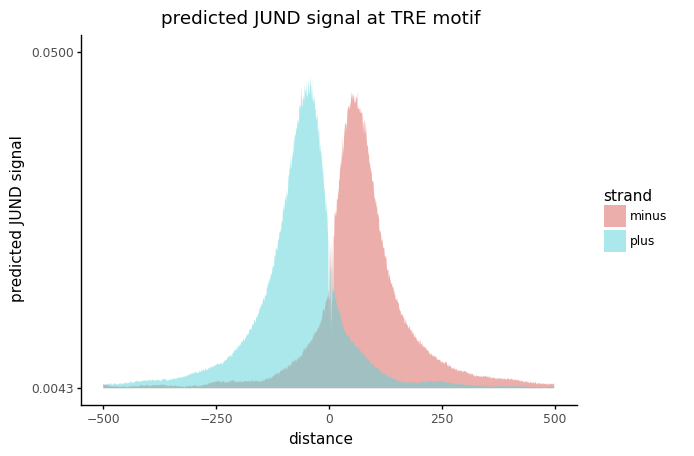

<ggplot: (8778007633777)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: predicted_JUND_signal_at_TRE_motif.pdf


In [11]:
output_seq_len = 1000
number_of_strands = 2
input_seq_len = 2114
task = 0
num_of_tasks = 1

motif = 'ATGACTCAT'
input_seq_len = 2114
motif_inserted_sequences = []
for sequence in sequences:
    inserted_sequence = (sequence[:(input_seq_len//2)] 
                        + motif 
                        + sequence[(input_seq_len//2)+len(motif):])
    motif_inserted_sequences.append(inserted_sequence+random_seq(input_seq_len-len(inserted_sequence)))
    
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
                   np.zeros(num_of_tasks*output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],num_of_tasks,output_seq_len,number_of_strands))])



plus,minus = calculate_average_profile(prediction,task=task)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted JUND signal",limits=(ymin,0.05),breaks=(ymin,0.05))
         +labs(title="predicted JUND signal at TRE motif")  
     )
print(plot)
plot.save("predicted_JUND_signal_at_TRE_motif.pdf")

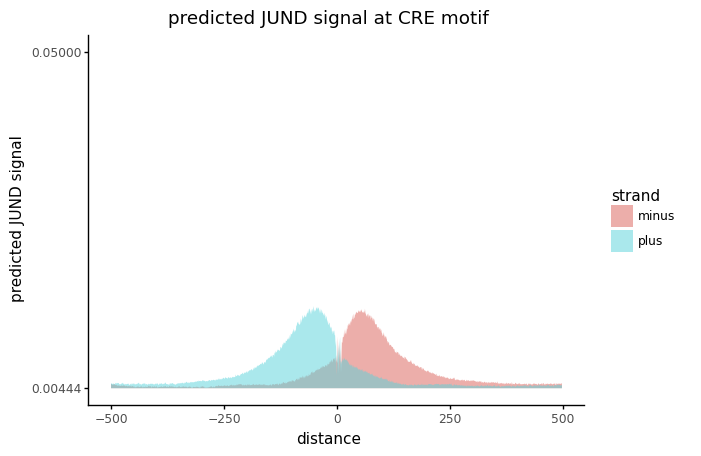

<ggplot: (8777948627057)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: predicted_JUND_signal_at_CRE_motif.pdf


In [12]:
output_seq_len = 1000
number_of_strands = 2
input_seq_len = 2114
task = 0
num_of_tasks = 1

motif = 'ATGACGTCAT'
input_seq_len = 2114
motif_inserted_sequences = []
for sequence in sequences:
    inserted_sequence = (sequence[:(input_seq_len//2)] 
                        + motif 
                        + sequence[(input_seq_len//2)+len(motif):])
    motif_inserted_sequences.append(inserted_sequence+random_seq(input_seq_len-len(inserted_sequence)))
    
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
                   np.zeros(num_of_tasks*output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],num_of_tasks,output_seq_len,number_of_strands))])



plus,minus = calculate_average_profile(prediction,task=task)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted JUND signal",limits=(ymin,0.05),breaks=(ymin,0.05))
         +labs(title="predicted JUND signal at CRE motif")  
     )
print(plot)
plot.save("predicted_JUND_signal_at_CRE_motif.pdf")

In [13]:
max_distance = 200
from tqdm import trange, tqdm
    

In [14]:

def get_suffled_peak_sequences(peak_path,fasta_path = '/users/zahoor/reference/hg38.genome.fa', input_seq_len = 2114,
                               num_of_simulated_sequences=1000):
    peaks_df = pd.read_csv(peak_path,
                           sep='\t',header=None,
                           names=['chrom', 'start', 'end', 'name', 'score',
                                      'strand', 'signalValue', 'p', 'q', 'summit'])

    peaks_df = peaks_df.sample(frac=1).reset_index(drop=True)

    fasta_ref = pysam.FastaFile(fasta_path)

    sequences = []

    Input_start = peaks_df['start'] + peaks_df['summit'] - (input_seq_len//2)
    Input_start = Input_start.mask(Input_start < 0,0)
    Input_end = peaks_df['start'] + peaks_df['summit'] + (input_seq_len//2)


    for i in range(num_of_simulated_sequences):
        actual_sequence = fasta_ref.fetch(peaks_df['chrom'][i], Input_start[i] , Input_end[i]).upper()
        padded_sequence = actual_sequence+(random_seq(input_seq_len-len(actual_sequence)))
        shuffled_seq = dinuc_shuffle(padded_sequence)
        sequences.append(shuffled_seq)
    
    return sequences

def predict_logits(encoded_inserted_sequences,output_seq_len = 1000,number_of_strands = 2,task=0,num_of_tasks=1):
    
    prediction = model.predict([encoded_inserted_sequences,
                   np.zeros(num_of_tasks*output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],num_of_tasks,output_seq_len,number_of_strands))])

    return prediction


def calculate_max_signal(prediction,max_signal_window,task=0):
    plus = []
    minus = []

    for i in range(len(prediction[1])):
        minus.append(logits_to_profile(logits_vals = prediction[0][i][task,:,0],counts_vals = prediction[1][i][task,0]))
        plus.append(logits_to_profile(logits_vals = prediction[0][i][task,:,1],counts_vals = prediction[1][i][task,1]))
        plus_max_avg = np.vstack(plus)[:,(output_seq_len//2)-(max_signal_window//2):(output_seq_len//2)+(max_signal_window//2)].max(axis=1).mean()
        minus_max_avg = np.vstack(minus)[:,(output_seq_len//2)-(max_signal_window//2):(output_seq_len//2)+(max_signal_window//2)].max(axis=1).mean()

    return(max(plus_max_avg,minus_max_avg))

    
def insert_two_motif_with_distance(motif_1,motif_2,distance,sequences):
    motif_inserted_sequences = []
    for sequence in sequences:
        inserted_sequence = (sequence[:(input_seq_len//2)] 
                            +motif_1 
                            +sequence[(input_seq_len//2)+len(motif_1):(input_seq_len//2)+len(motif_1)+distance]
                            +motif_2
                            +sequence[(input_seq_len//2)+len(motif_1)+distance+len(motif_2):])
        motif_inserted_sequences.append(inserted_sequence+random_seq(input_seq_len-len(inserted_sequence)))
    return motif_inserted_sequences

def simulate_distance_interaction(model,motif_1,motif_2,max_distance=200,max_signal_window=70,task=0,num_of_tasks=1):
    sequences = get_suffled_peak_sequences(peak_path, reference_genome, 2114, 100)
    max_signal = []
    for motif_distance in trange(max_distance):
        motif_inserted_sequences = insert_two_motif_with_distance(motif_1=motif_1,
                                                                  motif_2=motif_2,
                                                                  distance=motif_distance,
                                                                  sequences=sequences)
        encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)
        prediction = predict_logits(encoded_inserted_sequences = encoded_inserted_sequences,
                                    output_seq_len = 1000,
                                    number_of_strands = 2,task=task,num_of_tasks=num_of_tasks)
        max_signal.append((motif_distance,calculate_max_signal(prediction,max_signal_window,task=task)))
    return(max_signal)
        
        
 

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


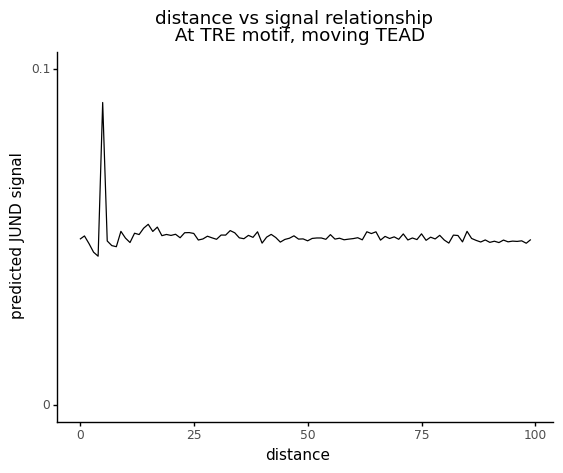

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: TRE_TEAD distance plot.pdf


<ggplot: (8777923782233)>


In [15]:
motif1 = 'ATGACTCAT'
motif2 = 'AGGAAT'

distance_signal_lst = simulate_distance_interaction(model,motif1,motif2,max_distance=100,task=task,num_of_tasks=num_of_tasks)
distance_signal_df = pd.DataFrame(distance_signal_lst, columns=['distance', 'signal'])

plot=(ggplot(distance_signal_df,aes('distance','signal'))
         +geom_line()
         +theme_classic()
         +scale_y_continuous(name ="predicted JUND signal",limits=(0,0.1),breaks=(0,0.1))
         +labs(title="distance vs signal relationship \n At TRE motif, moving TEAD")  
     )
print(plot)
plot.save("TRE_TEAD distance plot.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 10/10 [00:01<00:00,  7.17it/s]


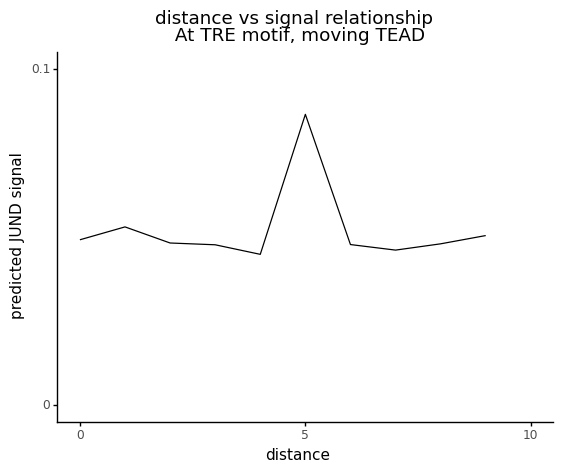

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: TRE_TEAD_distance_zoomed_plot.pdf


<ggplot: (8777923663929)>


In [16]:
motif1 = 'ATGACTCAT'
motif2 = 'AGGAAT'

distance_signal_lst = simulate_distance_interaction(model,motif1,motif2,max_distance=10,task=task,num_of_tasks=num_of_tasks)
distance_signal_df = pd.DataFrame(distance_signal_lst, columns=['distance', 'signal'])

plot=(ggplot(distance_signal_df,aes('distance','signal'))
         +geom_line()
         +theme_classic()
         +scale_y_continuous(name ="predicted JUND signal",limits=(0,0.1),breaks=(0,0.1))
         +scale_x_continuous(limits=(0,10),breaks=(0,5,10))


         +labs(title="distance vs signal relationship \n At TRE motif, moving TEAD")  
     )
print(plot)
plot.save("TRE_TEAD_distance_zoomed_plot.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 200/200 [00:27<00:00,  7.15it/s]


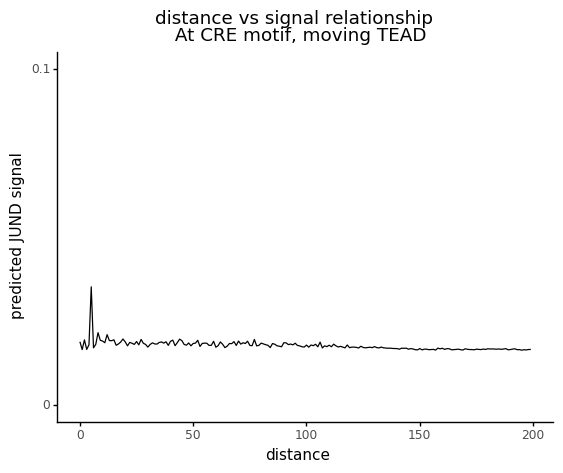

<ggplot: (8778007207741)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: CRE_TEAD distance plot.pdf


In [17]:
motif1 = 'ATGACGTCAT'
motif2 = 'AGGAAT'

distance_signal_lst = simulate_distance_interaction(model,motif1,motif2,task=task,num_of_tasks=num_of_tasks)
distance_signal_df = pd.DataFrame(distance_signal_lst, columns=['distance', 'signal'])

plot=(ggplot(distance_signal_df,aes('distance','signal'))
         +geom_line()
         +theme_classic()
         +scale_y_continuous(name ="predicted JUND signal",limits=(0,0.1),breaks=(0,0.1))
         +labs(title="distance vs signal relationship \n At CRE motif, moving TEAD")  
     )
print(plot)
plot.save("CRE_TEAD distance plot.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


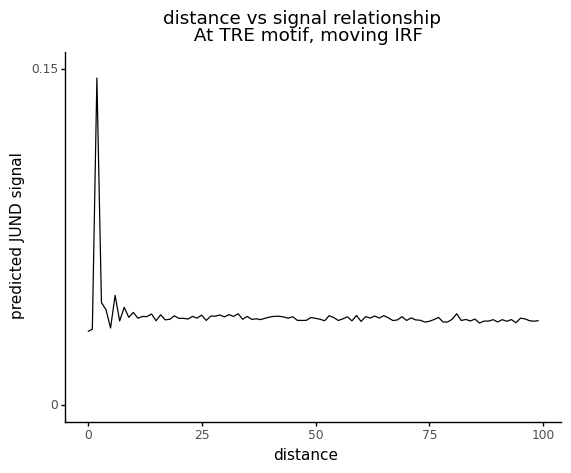

<ggplot: (8777529353149)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: TRE_IRF distance plot.pdf


In [28]:
model_path = '/oak/stanford/groups/akundaje/amtseng/tfmodisco/results/best_models_bigwigs/models/JUND_task7_model.h5'
reference_genome = '/users/zahoor/reference/hg38.genome.fa'
peak_path  = '/oak/stanford/groups/akundaje/amtseng/tfmodisco/results/best_models_bigwigs/peaks/JUND_task7_peaks.bed.gz'

# model = get_model(model_path=model_path)
# sequences = get_suffled_peak_sequences(peak_path)

motif1 = 'ATGACTCAT'
motif2 = 'CGAAAC'


distance_signal_lst = simulate_distance_interaction(model,motif1,motif2,max_distance=100,task=task,num_of_tasks=num_of_tasks)
distance_signal_df = pd.DataFrame(distance_signal_lst, columns=['distance', 'signal'])

plot=(ggplot(distance_signal_df,aes('distance','signal'))
         +geom_line()
         +theme_classic()
         +scale_y_continuous(name ="predicted JUND signal",limits=(0,0.15),breaks=(0,0.15))
         +labs(title="distance vs signal relationship \n At TRE motif, moving IRF")  
     )
print(plot)
plot.save("TRE_IRF distance plot.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


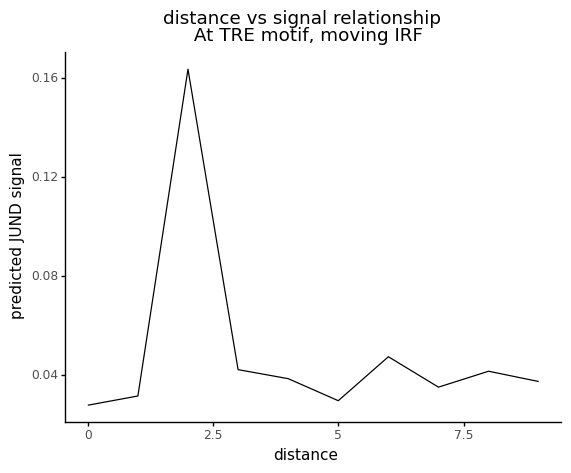

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: TRE_IRF distance plot.pdf


<ggplot: (8777529135325)>


In [32]:
motif1 = 'ATGACTCAT'
motif2 = 'CGAAAC'


distance_signal_lst = simulate_distance_interaction(model,motif1,motif2,max_distance=10,task=task,num_of_tasks=num_of_tasks)
distance_signal_df = pd.DataFrame(distance_signal_lst, columns=['distance', 'signal'])

plot=(ggplot(distance_signal_df,aes('distance','signal'))
         +geom_line()
         +theme_classic()
         +scale_y_continuous(name ="predicted JUND signal")
         +labs(title="distance vs signal relationship \n At TRE motif, moving IRF")  
     )
print(plot)
plot.save("TRE_IRF distance plot.pdf")